# TP 3
Camille BROSSETTE  
Maxime LEGRAND

### Data import

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from datetime import datetime

In [2]:
dft = {}
dft[1] = pd.read_pickle("./data/strades_info_720.h5")
dft[2] = pd.read_pickle('./data/strades_info_1102.h5')
dft[3] = pd.read_pickle('./data/strades_info_1662.h5')
dft[4] = pd.read_pickle('./data/strades_info_1664.h5')
dft[5] = pd.read_pickle('./data/strades_info_2255.h5')
dft[6] = pd.read_pickle('./data/strades_info_2574.h5')
dft[7] = pd.read_pickle('./data/strades_info_2586.h5')
dft[8] = pd.read_pickle('./data/strades_info_5685.h5')
dft[9] = pd.read_pickle('./data/strades_info_8695864.h5')

### Cleaning

In [4]:
for i in range(1,10):
    dti = dft[i]['ts_market'].iloc[0]
    dft[i] = dft[i][(dft[i]['bid'] < dft[i]['ask'])
                    &(dft[i]['bid'] != 0)
                    &(dft[i]['bid'] != 999999)
                    &(dft[i]['ask'] != 0)
                    &(dft[i]['ask'] != 999999)
                    &(dft[i]['volume'] != 0)
                    &(dft[i]['qty'] != 0)
                    &(dft[i]['side'] != 'U')]
    if i==2:
        dft[i] = dft[i][(dft[i]['ts_market'] > datetime(dti.year, dti.month, dti.day, 7, 0))
                         &(dft[i]['ts_market'] < datetime(dti.year, dti.month, dti.day, 15, 30))]
    else:
        dft[i] = dft[i][(dft[i]['ts_market'] > datetime(dti.year, dti.month, dti.day, 8, 0))
                         &(dft[i]['ts_market'] < datetime(dti.year, dti.month, dti.day, 16, 30))]

In [5]:
dftt = {}
for i in range(1,10):
    dftt[i] = dft[i].set_index('ts_market')

### Signature plot

In [49]:
def sign_vol(A, Time_Step):
    
    vol = A['price'].resample(Time_Step, how='first').fillna(method='ffill')
    vol = ((vol-vol.shift())**2)
    
    return vol.sum()

In [50]:
time_step = {}
m_range = range(1,1000,20)
for j in m_range:
    time_step[j] = (str(j) + 'ms')

In [51]:
Sign_Vol = [sign_vol(dftt[1], time_step[j]) for j in m_range]

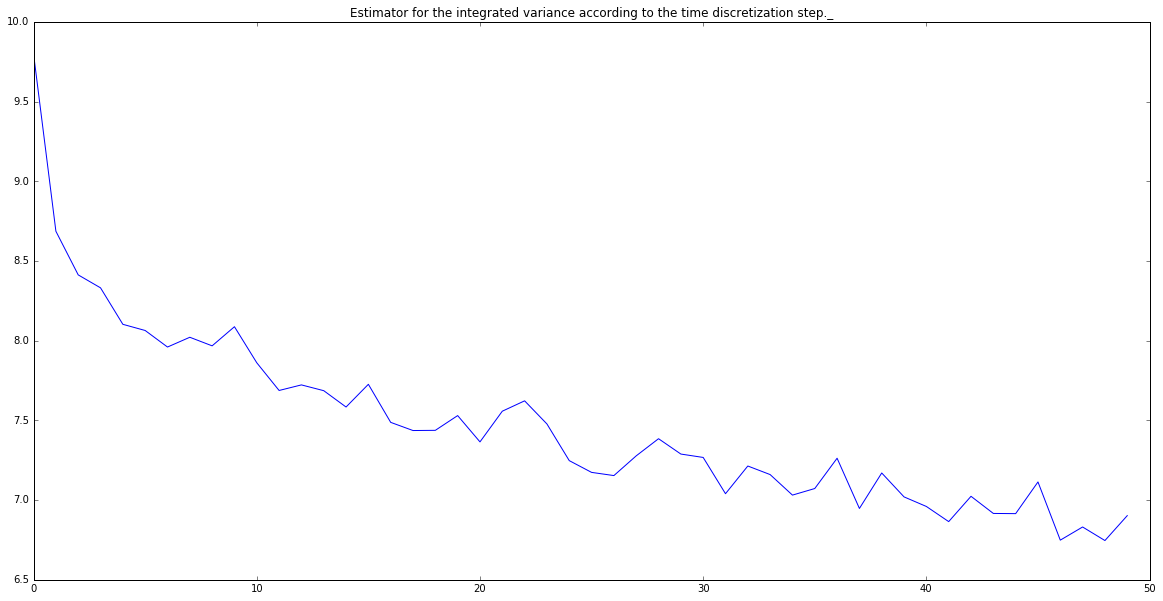

In [52]:
plt.figure(figsize = (20,10))
plt.plot(Sign_Vol)
plt.title('Estimator for the integrated variance according to the time discretization step._')

ça explose qd le pas de temps tend vers 0

### Intraday Volatility Estimator of Garman and Klass

In [75]:
def GK_Vol(A, Time_Step):
    
    High = A['price'].resample(Time_Step, how='max').fillna(method='ffill')
    Low = A['price'].resample(Time_Step, how='min').fillna(method='ffill')
    Open = A['price'].resample(Time_Step, how='first').fillna(method='ffill')
    Close = A['price'].resample(Time_Step, how='last').fillna(method='ffill')
    
    vol = 0.5*(High - Low)**2 - (2 * np.log(2) - 1)*(Close - Open)**2
    
    return np.sqrt(vol)

In [91]:
GK_vol_30sec = GK_Vol(dftt[1], '30s')
GK_vol_1Min = GK_Vol(dftt[1], '1Min')
GK_vol_2Min = GK_Vol(dftt[1], '2Min')
GK_vol_5Min = GK_Vol(dftt[1], '5Min')

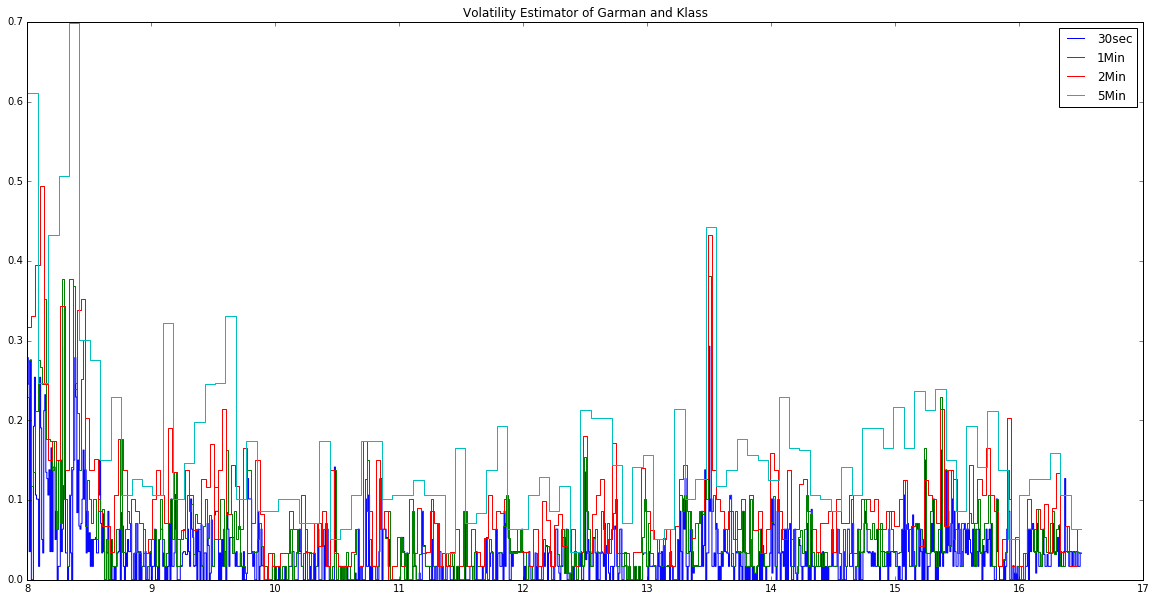

In [107]:
plt.figure(figsize = (20,10))

Time0 = np.linspace(8,16.5,len(GK_vol_30sec))
Time1 = np.linspace(8,16.5,len(GK_vol_1Min))
Time2 = np.linspace(8,16.5,len(GK_vol_2Min))
Time5 = np.linspace(8,16.5,len(GK_vol_5Min))

plt.step(Time0, GK_vol_30sec, label = '30sec')
plt.step(Time1, GK_vol_1Min, label = '1Min')
plt.step(Time2, GK_vol_2Min, label = '2Min')
plt.step(Time5, GK_vol_5Min, label = '5Min')

plt.title('Volatility Estimator of Garman and Klass')
plt.legend()

plus on affine le pas, plus la vol estimée est petite

### Intraday Volatility Estimator (natural)

In [99]:
def Classic_Vol(A, time_step):
    
    vol = (((A['price'].diff())**2).resample(time_step, how='sum')).apply(np.sqrt)
    
    return vol    

In [105]:
classic_vol_30sec = Classic_Vol(dftt[1], '30s')
classic_vol_1Min = Classic_Vol(dftt[1], '1Min')
classic_vol_2Min = Classic_Vol(dftt[1], '2Min')
classic_vol_5Min = Classic_Vol(dftt[1], '5Min')

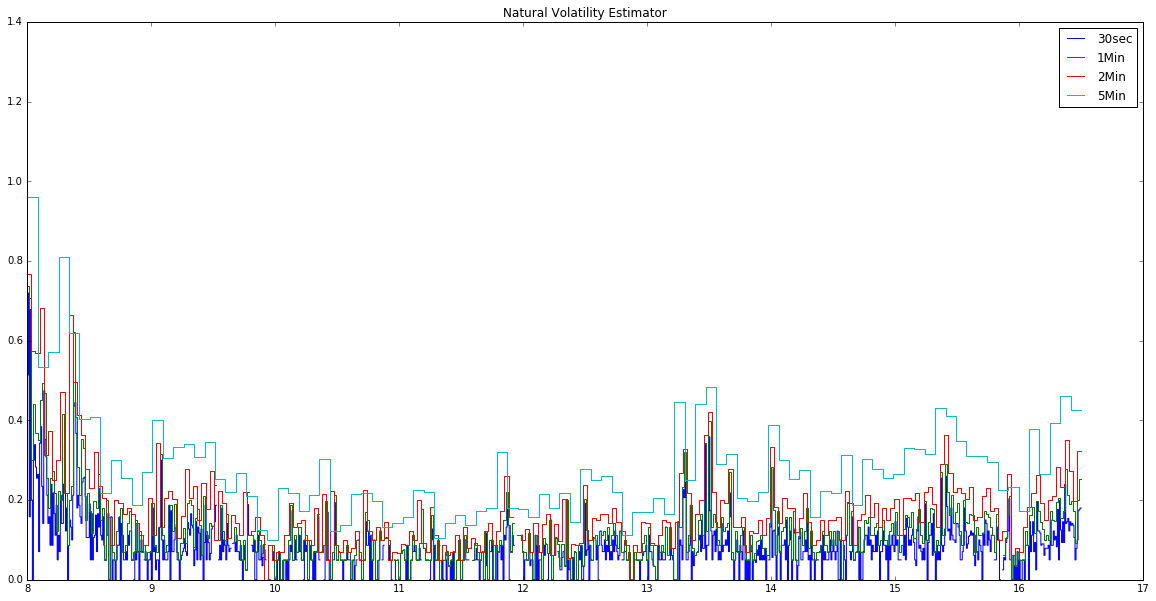

In [114]:
plt.figure(figsize = (20,10))

plt.step(Time0, classic_vol_30sec, label = '30sec')
plt.step(Time1, classic_vol_1Min, label = '1Min')
plt.step(Time2, classic_vol_2Min, label = '2Min')
plt.step(Time5, classic_vol_5Min, label = '5Min')

plt.title('Natural Volatility Estimator')
plt.legend()

plus on affine le pas de temps, plus la classique vol surestime par rapport à la GK

### Comparaison des estimateurs

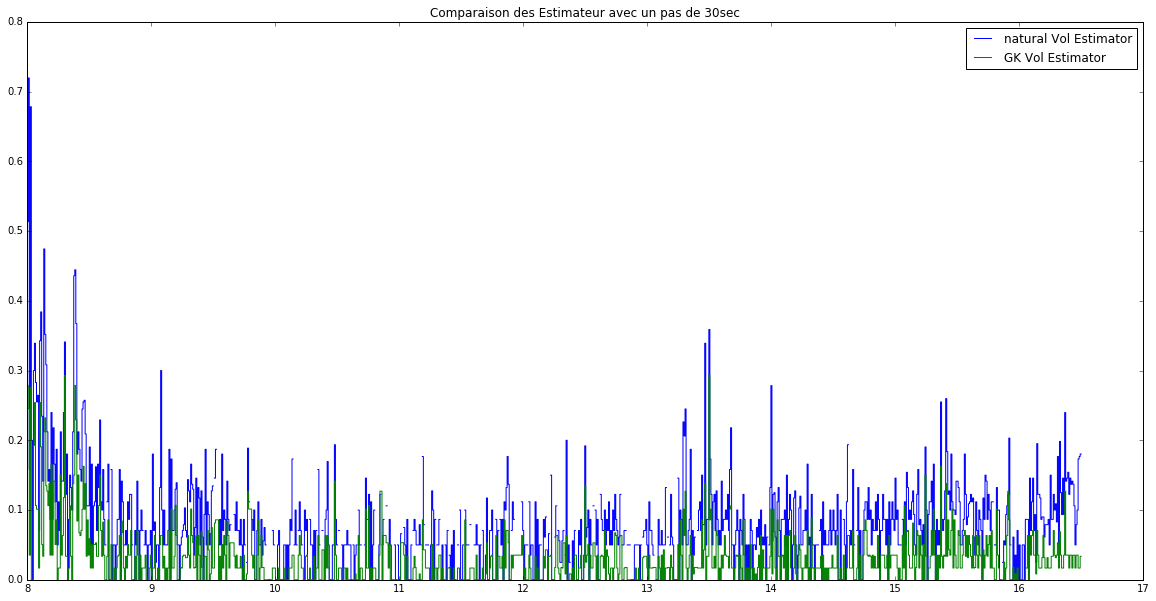

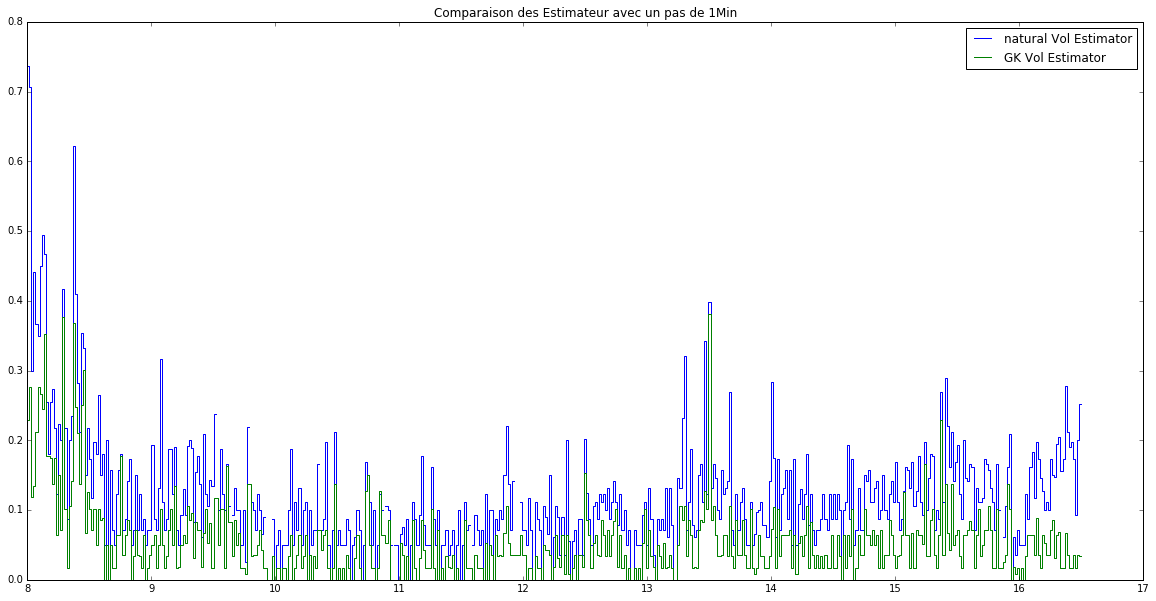

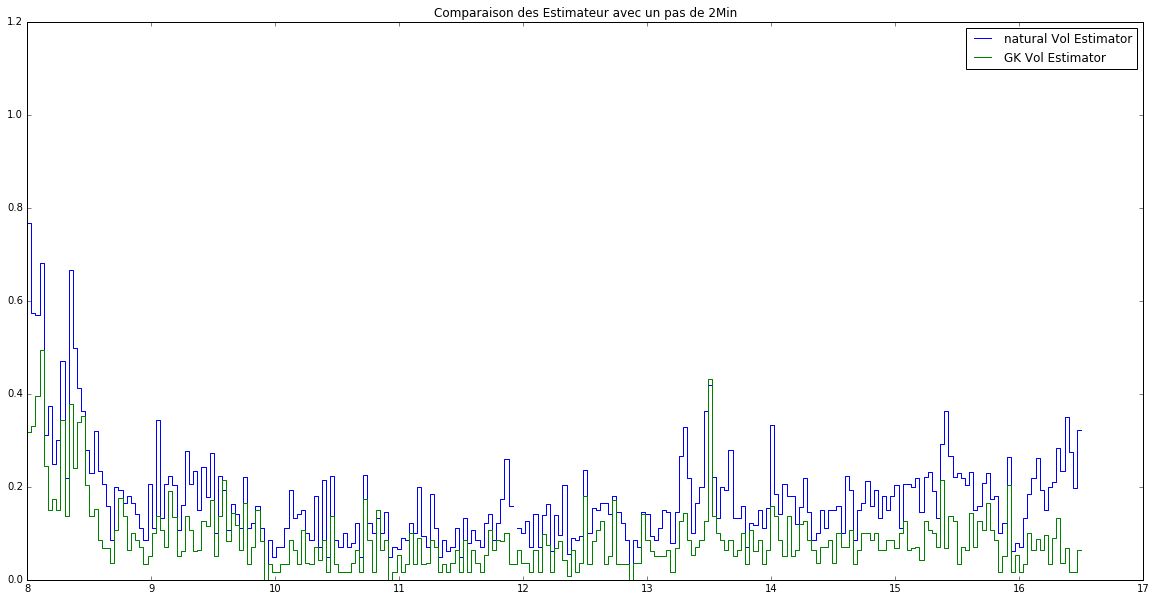

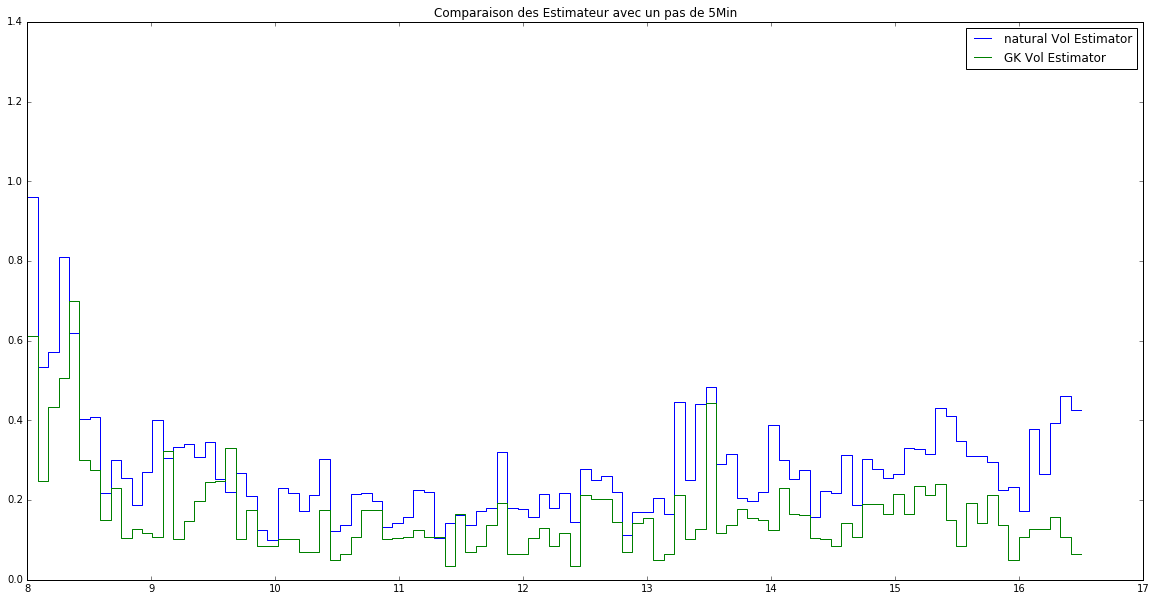

In [117]:
plt.figure(figsize = (20,10))
plt.step(Time0 ,classic_vol_30sec, label='natural Vol Estimator')
plt.step(Time0, GK_vol_30sec, label='GK Vol Estimator')
plt.title('Comparaison des Estimateur avec un pas de 30sec')
plt.legend()

plt.figure(figsize = (20,10))
plt.step(Time1 ,classic_vol_1Min, label='natural Vol Estimator')
plt.step(Time1, GK_vol_1Min, label='GK Vol Estimator')
plt.title('Comparaison des Estimateur avec un pas de 1Min')
plt.legend()

plt.figure(figsize = (20,10))
plt.step(Time2 ,classic_vol_2Min, label='natural Vol Estimator')
plt.step(Time2, GK_vol_2Min, label='GK Vol Estimator')
plt.title('Comparaison des Estimateur avec un pas de 2Min')
plt.legend()

plt.figure(figsize = (20,10))
plt.step(Time5 ,classic_vol_5Min, label='natural Vol Estimator')
plt.step(Time5, GK_vol_5Min, label='GK Vol Estimator')
plt.title('Comparaison des Estimateur avec un pas de 5Min')
plt.legend()